## Exercise 1 - Constrained Autoencoders

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Test MSE: 0.048003267
Epoch: 1 Test MSE: 0.044414304
Epoch: 2 Test MSE: 0.044283558
Epoch: 3 Test MSE: 0.044295073
Epoch: 4 Test MSE: 0.04439807


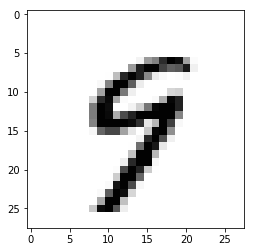

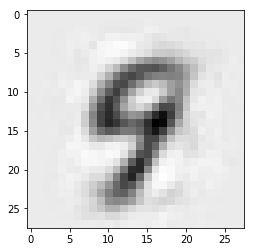

In [1]:
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


# matplotlib settings
%matplotlib inline

# load data
mnist = input_data.read_data_sets("/tmp/data/")

# network settings
n_inputs = 28 * 28
n_hidden1 = 256
n_hidden2 = 128
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.001
initializer = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

# define placeholder
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])

# define graph
W_1_init = initializer((n_inputs, n_hidden1))
W_2_init = initializer((n_hidden1, n_hidden2))
# W_1 = tf.Variable(tf.truncated_normal((n_inputs, n_hidden1)), dtype=tf.float32)
# W_2 = tf.Variable(tf.truncated_normal((n_hidden1, n_hidden2)), dtype=tf.float32)
W_1 = tf.Variable(W_1_init, dtype=tf.float32)
W_2 = tf.Variable(W_2_init, dtype=tf.float32)
W_3 = tf.transpose(W_2)
W_4 = tf.transpose(W_1)


b_1 = tf.Variable(tf.zeros((n_hidden1)), dtype=tf.float32)
b_2 = tf.Variable(tf.zeros((n_hidden2)), dtype=tf.float32)
b_3 = tf.Variable(tf.zeros((n_hidden3)), dtype=tf.float32)
b_4 = tf.Variable(tf.zeros((n_outputs)), dtype=tf.float32)

hidden1 = tf.nn.elu(tf.matmul(X_placeholder, W_1) + b_1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W_2) + b_2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W_3) + b_3)
outputs = tf.matmul(hidden3, W_4) + b_4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X_placeholder))
regularization_loss = regularizer(W_1) + regularizer(W_2)
loss = reconstruction_loss + regularization_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# create a node to initialize our global variables
init = tf.global_variables_initializer()

# training settings
n_epochs = 5
batch_size = 100
n_batches = mnist.train.num_examples // batch_size
X_test = mnist.test.images

# execute graph
with tf.Session() as sess:
    init.run()
    for n_epoch in range(n_epochs):
        for n_batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X_placeholder: X_batch})
        loss_eval = loss.eval(feed_dict={X_placeholder: X_test})
        print('Epoch:', n_epoch, 'Test MSE:', loss_eval)
    
    # show random test example
    X_test, _ = mnist.test.next_batch(1)
    fig1 = plt.figure()
    plt.imshow(X_test.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    fig2 = plt.figure()
    X_test_eval = sess.run(outputs, feed_dict={X_placeholder: X_test})
    plt.imshow(X_test_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()

## Exercise 2 - Denoising Autoencoders

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Test MSE: 0.03432975
Epoch: 1 Test MSE: 0.033187825
Epoch: 2 Test MSE: 0.032501254
Epoch: 3 Test MSE: 0.032202665
Epoch: 4 Test MSE: 0.032127205


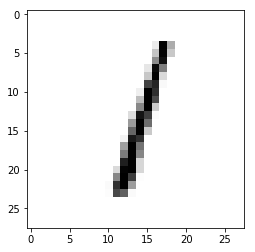

Original Image


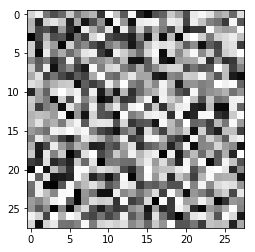

Noise


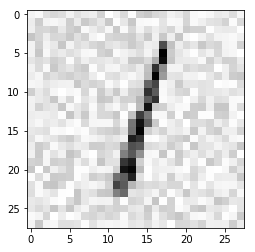

Input to model: Original Image + Noise


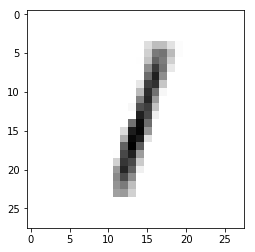

Output from model: Denoised Image


In [2]:
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data


# matplotlib settings
%matplotlib inline

# load data
mnist = input_data.read_data_sets("/tmp/data/")

# network settings
n_inputs = 28 * 28
n_hidden1 = 128
n_hidden2 = 64
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01

# define placeholder
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])

# define graph
hidden1 = fully_connected(X_noisy_placeholder, n_hidden1)
hidden2 = fully_connected(hidden1, n_hidden2)
hidden3 = fully_connected(hidden2, n_hidden3)
outputs = fully_connected(hidden3, n_outputs)
loss = tf.reduce_mean(tf.square(outputs - X_placeholder))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# create a node to initialize our global variables
init = tf.global_variables_initializer()

# training settings
n_epochs = 5
batch_size = 100
n_batches = mnist.train.num_examples // batch_size
X_test = mnist.test.images
noise_test = np.random.uniform(0, 0.5, (mnist.test.num_examples, 784))
X_noisy_test = X_test + noise_test
feed_dict_test = {X_placeholder: X_test, X_noisy_placeholder: X_noisy_test}

# execute graph
with tf.Session() as sess:
    init.run()
    for n_epoch in range(n_epochs):
        for n_batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            noise = np.random.uniform(0, 0.5, (batch_size, 784))
            X_noisy_batch = X_batch +  noise
            feed_dict_train = {X_placeholder: X_batch, 
                               X_noisy_placeholder: X_noisy_batch}
            sess.run(train_op, feed_dict=feed_dict_train)
        loss_eval = loss.eval(feed_dict=feed_dict_test)
        print('Epoch:', n_epoch, 'Test MSE:', loss_eval)
    
    # show test example
    index = 2  # change this to pick another test example
    fig1 = plt.figure()
    plt.imshow(X_test[index].reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Original Image')
    fig2 = plt.figure()
    plt.imshow(noise_test[index].reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Noise')
    fig3 = plt.figure()
    plt.imshow(X_noisy_test[index].reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Input to model: Original Image + Noise')
    fig4 = plt.figure()
    X_test_eval = sess.run(outputs, feed_dict={X_placeholder: X_test[index:index + 1], 
                                               X_noisy_placeholder: X_noisy_test[index:index + 1]})
    plt.imshow(X_test_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Output from model: Denoised Image')

## Exercise 3 - Sparse Autoencoders

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Test MSE: 686872.0
Epoch: 1 Test MSE: 611968.3
Epoch: 2 Test MSE: 581348.06
Epoch: 3 Test MSE: 564478.5
Epoch: 4 Test MSE: 557722.06
Epoch: 5 Test MSE: 548542.3
Epoch: 6 Test MSE: 546227.56
Epoch: 7 Test MSE: 544371.25
Epoch: 8 Test MSE: 542068.75
Epoch: 9 Test MSE: 541411.06


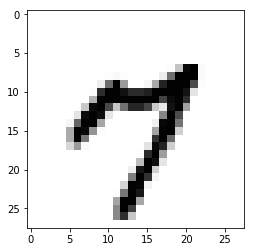

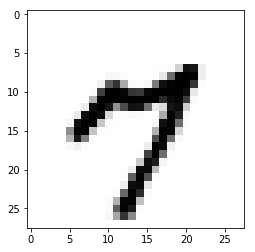

In [3]:
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


# matplotlib settings
%matplotlib inline

# load data
mnist = input_data.read_data_sets("/tmp/data/")

# network settings
n_inputs = 28 * 28
n_hidden1 = 128
n_outputs = n_inputs
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2
initializer = tf.contrib.layers.variance_scaling_initializer()

# define placeholder
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])

# define graph
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - q) * tf.log((1 - p) / (1 - q))

W_1_init = initializer((n_inputs, n_hidden1))
W_2_init = initializer((n_hidden1, n_outputs))
W_1 = tf.Variable(W_1_init, dtype=tf.float32)
W_2 = tf.Variable(W_2_init, dtype=tf.float32)
b_1 = tf.Variable(tf.zeros((n_hidden1)), dtype=tf.float32)
b_2 = tf.Variable(tf.zeros((n_outputs)), dtype=tf.float32)
hidden1 = tf.nn.sigmoid(tf.matmul(X_placeholder, W_1) + b_1)
logits = tf.matmul(hidden1, W_2) + b_2
outputs = tf.nn.sigmoid(logits)

hidden1_mean = tf.reduce_mean(hidden1, axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
# reconstruction_loss = tf.reduce_mean(tf.square(outputs - X_placeholder))
reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_placeholder, logits=logits))
loss = reconstruction_loss + sparsity_weight * sparsity_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# create a node to initialize our global variables
init = tf.global_variables_initializer()

# training settings
n_epochs = 10
batch_size = 100
n_batches = mnist.train.num_examples // batch_size
X_test = mnist.test.images

# execute graph
with tf.Session() as sess:
    init.run()
    for n_epoch in range(n_epochs):
        for n_batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X_placeholder: X_batch})
        loss_eval = loss.eval(feed_dict={X_placeholder: X_test})
        print('Epoch:', n_epoch, 'Test MSE:', loss_eval)
    
    # show random test example
    X_test, _ = mnist.test.next_batch(1)
    fig1 = plt.figure()
    plt.imshow(X_test.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    fig2 = plt.figure()
    X_test_eval = sess.run(outputs, feed_dict={X_placeholder: X_test})
    plt.imshow(X_test_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()

## Exercise 4 - Variational Autoencoders

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Test MSE: 3120423.8
Epoch: 1 Test MSE: 3049155.5
Epoch: 2 Test MSE: 3017335.2
Epoch: 3 Test MSE: 3012745.5
Epoch: 4 Test MSE: 3008715.0
Epoch: 5 Test MSE: 2992171.5
Epoch: 6 Test MSE: 3002723.8
Epoch: 7 Test MSE: 2997291.2
Epoch: 8 Test MSE: 2987564.5
Epoch: 9 Test MSE: 2987814.5


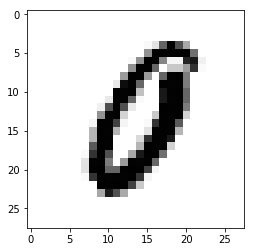

Original Image


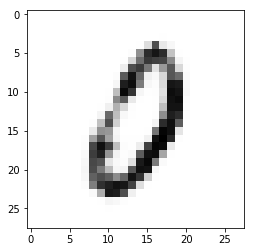

Reconstructed Image


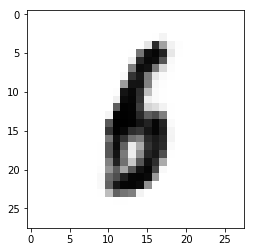

Image Generated from Random Noise passed into Codings


In [4]:
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data


# matplotlib settings
%matplotlib inline

# load data
mnist = input_data.read_data_sets("/tmp/data/")

# network settings
n_inputs = 28 * 28
n_hidden1 = 128
n_hidden2 = 64
n_hidden3 = 32
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01

# define placeholder
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])

# define graph
with tf.contrib.framework.arg_scope([fully_connected], 
                                   activation_fn=tf.nn.elu, 
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer()):
    hidden1 = fully_connected(X_placeholder, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3_mean = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_sigma = tf.exp(0.5 * hidden3_gamma)
    noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
    hidden3 = hidden3_mean + hidden3_sigma * noise
    hidden4 = fully_connected(hidden3, n_hidden4)
    hidden5 = fully_connected(hidden4, n_hidden5)
    logits = fully_connected(hidden5, n_outputs)
    outputs = tf.nn.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_placeholder, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# create a node to initialize our global variables
init = tf.global_variables_initializer()

# training settings
n_epochs = 10
batch_size = 100
n_batches = mnist.train.num_examples // batch_size
X_test = mnist.test.images

# execute graph
with tf.Session() as sess:
    init.run()
    for n_epoch in range(n_epochs):
        for n_batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X_placeholder: X_batch})
        loss_eval = loss.eval(feed_dict={X_placeholder: X_test})
        print('Epoch:', n_epoch, 'Test MSE:', loss_eval)
    
    # show random test example
    X_test, _ = mnist.test.next_batch(1)
    fig1 = plt.figure()
    plt.imshow(X_test.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Original Image')
    fig2 = plt.figure()
    X_test_eval = sess.run(outputs, feed_dict={X_placeholder: X_test})
    plt.imshow(X_test_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Reconstructed Image')
    fig3 = plt.figure()
    X_test_codings = np.random.normal(size=(1, n_hidden3))
    X_test_codings_eval = sess.run(outputs, feed_dict={hidden3: X_test_codings})
    plt.imshow(X_test_codings_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Image Generated from Random Noise passed into Codings')

## Exercise 5 - Anomaly Detection using Autoencoders

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Test MSE: 0.024841223
Epoch: 1 Test MSE: 0.022647224
Epoch: 2 Test MSE: 0.021176025
Epoch: 3 Test MSE: 0.020910671
Epoch: 4 Test MSE: 0.020760698


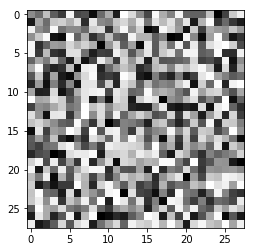

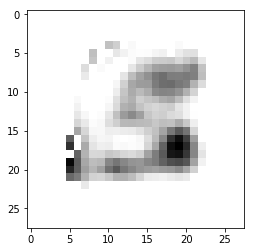

Reconstruction loss: 23570.584


In [5]:
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data


# matplotlib settings
%matplotlib inline

# load data
mnist = input_data.read_data_sets("/tmp/data/")

# network settings
n_inputs = 28 * 28
n_hidden1 = 128
n_hidden2 = 64
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01

# define placeholder
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])

# define graph
hidden1 = fully_connected(X_placeholder, n_hidden1)
hidden2 = fully_connected(hidden1, n_hidden2)
hidden3 = fully_connected(hidden2, n_hidden3)
outputs = fully_connected(hidden3, n_outputs)
loss = tf.reduce_mean(tf.square(outputs - X_placeholder))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# create a node to initialize our global variables
init = tf.global_variables_initializer()

# training settings
n_epochs = 5
batch_size = 100
n_batches = mnist.train.num_examples // batch_size
X_test = mnist.test.images

# execute graph
with tf.Session() as sess:
    init.run()
    for n_epoch in range(n_epochs):
        for n_batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X_placeholder: X_batch})
        loss_eval = loss.eval(feed_dict={X_placeholder: X_test})
        print('Epoch:', n_epoch, 'Test MSE:', loss_eval)
    
    # show random test example
    X_test = np.random.uniform(0, 255, (1, 784))
    fig1 = plt.figure()
    plt.imshow(X_test.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    fig2 = plt.figure()
    X_test_eval = sess.run(outputs, feed_dict={X_placeholder: X_test})
    plt.imshow(X_test_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    X_test_loss_eval = loss.eval(feed_dict={X_placeholder: X_test})
    print('Reconstruction loss:', X_test_loss_eval)

## Exercise 6 - To be edited.

To be edited.

## Exercise 7 - To be edited.

To be edited.

## Exercise 8 - To be edited.

To be edited.

## Exercise 9 - To be edited.

To be edited.